Hamming Weight:  
&emsp;calculate the number of 1 in 8 bit mid value  
$$HW(z) = \sum_{i=0}^{7}b_i\quad\quad z=(b_0,b_1,...,b_7)_2$$

In [1]:
import numpy as np
import json
import h5py

In [2]:
AES_Sbox = np.array([
    0x63, 0x7C, 0x77, 0x7B, 0xF2, 0x6B, 0x6F, 0xC5, 0x30, 0x01, 0x67, 0x2B,
    0xFE, 0xD7, 0xAB, 0x76, 0xCA, 0x82, 0xC9, 0x7D, 0xFA, 0x59, 0x47, 0xF0,
    0xAD, 0xD4, 0xA2, 0xAF, 0x9C, 0xA4, 0x72, 0xC0, 0xB7, 0xFD, 0x93, 0x26,
    0x36, 0x3F, 0xF7, 0xCC, 0x34, 0xA5, 0xE5, 0xF1, 0x71, 0xD8, 0x31, 0x15,
    0x04, 0xC7, 0x23, 0xC3, 0x18, 0x96, 0x05, 0x9A, 0x07, 0x12, 0x80, 0xE2,
    0xEB, 0x27, 0xB2, 0x75, 0x09, 0x83, 0x2C, 0x1A, 0x1B, 0x6E, 0x5A, 0xA0,
    0x52, 0x3B, 0xD6, 0xB3, 0x29, 0xE3, 0x2F, 0x84, 0x53, 0xD1, 0x00, 0xED,
    0x20, 0xFC, 0xB1, 0x5B, 0x6A, 0xCB, 0xBE, 0x39, 0x4A, 0x4C, 0x58, 0xCF,
    0xD0, 0xEF, 0xAA, 0xFB, 0x43, 0x4D, 0x33, 0x85, 0x45, 0xF9, 0x02, 0x7F,
    0x50, 0x3C, 0x9F, 0xA8, 0x51, 0xA3, 0x40, 0x8F, 0x92, 0x9D, 0x38, 0xF5,
    0xBC, 0xB6, 0xDA, 0x21, 0x10, 0xFF, 0xF3, 0xD2, 0xCD, 0x0C, 0x13, 0xEC,
    0x5F, 0x97, 0x44, 0x17, 0xC4, 0xA7, 0x7E, 0x3D, 0x64, 0x5D, 0x19, 0x73,
    0x60, 0x81, 0x4F, 0xDC, 0x22, 0x2A, 0x90, 0x88, 0x46, 0xEE, 0xB8, 0x14,
    0xDE, 0x5E, 0x0B, 0xDB, 0xE0, 0x32, 0x3A, 0x0A, 0x49, 0x06, 0x24, 0x5C,
    0xC2, 0xD3, 0xAC, 0x62, 0x91, 0x95, 0xE4, 0x79, 0xE7, 0xC8, 0x37, 0x6D,
    0x8D, 0xD5, 0x4E, 0xA9, 0x6C, 0x56, 0xF4, 0xEA, 0x65, 0x7A, 0xAE, 0x08,
    0xBA, 0x78, 0x25, 0x2E, 0x1C, 0xA6, 0xB4, 0xC6, 0xE8, 0xDD, 0x74, 0x1F,
    0x4B, 0xBD, 0x8B, 0x8A, 0x70, 0x3E, 0xB5, 0x66, 0x48, 0x03, 0xF6, 0x0E,
    0x61, 0x35, 0x57, 0xB9, 0x86, 0xC1, 0x1D, 0x9E, 0xE1, 0xF8, 0x98, 0x11,
    0x69, 0xD9, 0x8E, 0x94, 0x9B, 0x1E, 0x87, 0xE9, 0xCE, 0x55, 0x28, 0xDF,
    0x8C, 0xA1, 0x89, 0x0D, 0xBF, 0xE6, 0x42, 0x68, 0x41, 0x99, 0x2D, 0x0F,
    0xB0, 0x54, 0xBB, 0x16
])

In [3]:
with open('../utils.json', 'r') as f:    
    json_data = json.load(f)
    file_path = json_data['data']['path']

In [4]:
with h5py.File(file_path, 'r') as h5f:
    traces = h5f['traces'][()]
    plaintexts = h5f['plaintext'][()]
    ciphertexts = h5f['ciphertext'][()]
    keys = h5f['keys'][()]

### 计算第三字节中间值

In [5]:
def cal_hw_midval(plaintexts, keys, position):
    mid_val = np.zeros(shape=(plaintexts.shape[0], 1), dtype=int)
    for index, plaintext in enumerate(plaintexts):
        mid_val[index] = get_hw(AES_Sbox[keys[index][position] ^ plaintext[position]])
    return mid_val

def get_hw(mid_val):
    return bin(mid_val).count('1')

### 计算猜测熵

In [17]:
# 按照midval对trace进行分组
def group_traces(traces, labels):
    unique_label_set = np.unique(labels)
    # 初始化分组
    group_dict = {}
    for unique_label in unique_label_set:
        group_dict[unique_label] = []

    for index, label in enumerate(labels):
        group_dict[label[0]].append(traces[index])
    return group_dict

    
def snr(traces, labels):
    mean_traces_group = {}    # 存放traces分组后的均值
    mean_arr = []
    noise_arr = []
    
    grouped_traces = group_traces(traces, labels)
    unique_label_set = np.unique(labels)
    
    for unique_label in unique_label_set:
        mean_traces_group[unique_label] = np.mean(grouped_traces[unique_label], axis=0)
        mean_arr.append(mean_traces_group[unique_label])
    
    for unique_label in unique_label_set:
        for trace in grouped_traces[unique_label]:
            noise_arr.append(trace - mean_traces_group[unique_label])
    
    var_noise = np.var(noise_arr, axis=0)
    var_mean = np.var(mean_arr, axis=0)
    snr_traces = var_mean / var_noise

    return snr_traces

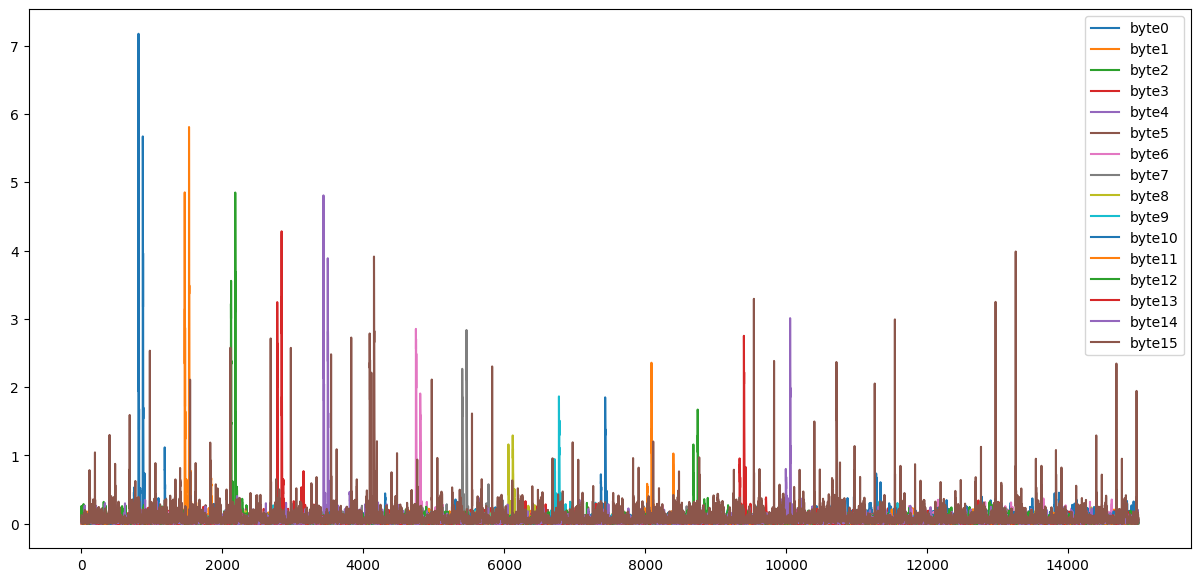

In [27]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 7))
for i in range(16):
    mid_val = cal_hw_midval(plaintexts, keys, i)
    plt.plot(range(15000), snr(traces, mid_val), label='byte' + str(i))
plt.legend()
plt.savefig('./res.png')
plt.show()